# Banking Marketing Targets

https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets

Tushar (tk22994)

Nandu (nrv379)

Mehdi (ma57795)

Sean (sha567)

# Introduction

Given direct marketing campaign data from a Portuguese banking institution, can we predict if a client will subscribe to a term deposit?

A term deposit is a fixed-term investment that includes the deposit of money into an account at a financial institution. These investments usually carry short-term maturities ranging from just a month, to a couple years. A client's money is invested for a certain rate of interest over the whole term.

Term deposits also happen to be a significant source of income for banks. One way that banks will advertise term deposits is through telephonic marketing, which is considered to be one of the more viable marketing methods. However, telephonic marketing campaigns generate large costs through the hiring of call centers. Therefore, it is financially prudent for banks to figure out which customers are the most likely to convert first, and then proceed with targeting them with telephonic marketing after.

## Feature Descriptions

### General Client Data

* age - numeric

* job - categorical

* marital - marital status; categorical

* education - categorical

* default - binary categorical

* balance - average yearly balance; numeric

* housing - has housing loan; binary categorical

* loan - has personal loan; binary categorical

### Data related to last contact of the current campaign

* contact - contact communication type; categorical

* day - last contact day of the month; numerical

* month - last contact month of the year; categorical

* duration - last contact duration, in seconds; numeric

* campaign - number of contacts performed during this campaign and for this client; numeric

* pdays - number of days that passed by after the client was last contacted from a previous campaign (-1 means client was not previously contacted); numeric

* previous - number of contacts performed before this campaign and for this client; numeric

* poutcome - outcome of the previous marketing campaign; categorical

### Label

* y - has the client subscribed a term deposit?; binary categorical

# Data Science

From here, proceed with the data science. Perform data cleaning, data exploration, feature engineering, etc. Use the markdown cells to describe and clarify each part of the process, so that a reader can easily follow along with what you've done.

In [13]:
# import libraries/ standard headers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%pip install imblearn

# enable inline mode for matplotlib so that Jupyter displays graphs
%matplotlib inline

# pandas version we're using
pd.__version__ 

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


'1.2.5'

## Data Exploration and Cleaning

As always, let us start off with reading in our dataset. Along the way, we will visualize and interpret our data to figure how to best clean and take advantage of it.

In [14]:
# read in the dataset
df = pd.read_csv("dataset/train.csv", sep=";")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### A Bivariate Introduction

Before manipulating the data, we want to intuitively see how the different features work together. Let's create a couple of bivariate graphs to understand how each row (client) might compare to each other.

<AxesSubplot:xlabel='job', ylabel='age'>

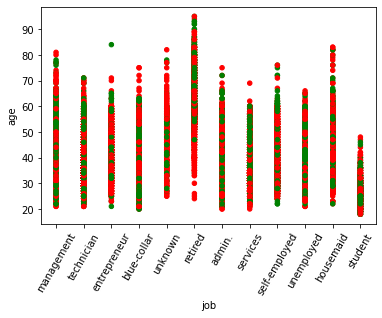

In [15]:
# What is the age-range in each industry, and how often do they subscribe a term deposit?
# Obviously students are the youngest, and retired are the oldest (although we have some retiring at sub-30)
# It seems that the yes's are distributed relatively evenly across jobs and ages.
colors = {'no': 'red', 'yes': 'green'}
df.plot.scatter('job', 'age', c=df['y'].map(colors), rot=60)

<AxesSubplot:xlabel='job', ylabel='balance'>

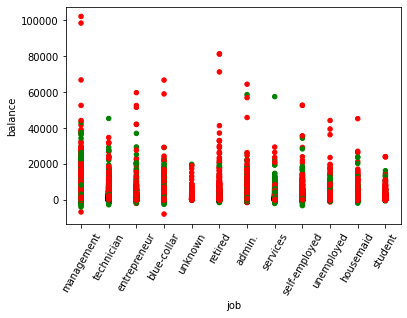

In [16]:
# Next, let's see if we can find the jobs with the highest balance!
# Obviously, management wins by far, followed by retired
# Interestingly enough, people with ultra-high balances (60k+) generally don't seem to bother
# with term deposits, although they are definitely outliers
# While we can see that people up to 40k balance might by a term deposit, one
# has to wonder how much these actually benefit the average person rather than just the bank
df.plot.scatter('job', 'balance', c=df['housing'].map(colors), rot=60)

<AxesSubplot:xlabel='month', ylabel='day'>

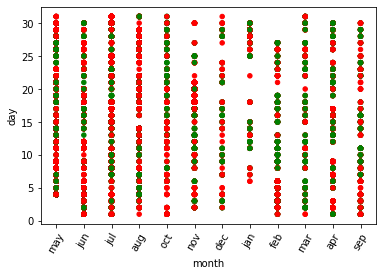

In [17]:
# Finally, let's put month against day!
# The graph definitely resembles a calendar, and the green dots
# are most easily seen in this graph.
# One interesting thing to note is that there seems to be a dry spell in mid-late August
# where not many people were subscribing term deposits.
df.plot.scatter('month', 'day', c=df['y'].map(colors), rot=60)

Now that we've gotten more familiar with the dataset, let's analyze the features more closely, and see if there is any cleaning or manipulation necessary to enhance our models.

## Categorical Features

While printing the .info() shows that we do not have any NULL values, further exploration shows that certain categorical columns have an "unknown" category.

Presented below is the category frequencies for all the categorical features. This brings to light some interesting insights:

1. Were the categories inputted correctly (consistency)?

Answer: They appear to be inputted consistently!

2. How prevalent is the "unknown" category throughout the dataset?

Answer: Looking below, we can see that 0.6% of jobs were unknown, 4.1% of educations were unknown, 28.8% of contact methods were unknown, and 81.7% of poutcomes were unknown. We will handle this case-by-case.

3. How might we want to engineer our categorical features?
Answer: We will perform one-hot encoding on non-binary features and map the binary features into 0 and 1 accordingly.

In [18]:
categorical_features = ["job", "marital", "education", "default", "housing", "loan", 'contact',"poutcome"]
for col in categorical_features:
    print(df[col].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
    print()

blue-collar      21.5%
management       20.9%
technician       16.8%
admin.           11.4%
services          9.2%
retired           5.0%
self-employed     3.5%
entrepreneur      3.3%
unemployed        2.9%
housemaid         2.7%
student           2.1%
unknown           0.6%
Name: job, dtype: object

married     60.2%
single      28.3%
divorced    11.5%
Name: marital, dtype: object

secondary    51.3%
tertiary     29.4%
primary      15.2%
unknown       4.1%
Name: education, dtype: object

no     98.2%
yes     1.8%
Name: default, dtype: object

yes    55.6%
no     44.4%
Name: housing, dtype: object

no     84.0%
yes    16.0%
Name: loan, dtype: object

cellular     64.8%
unknown      28.8%
telephone     6.4%
Name: contact, dtype: object

unknown    81.7%
failure    10.8%
other       4.1%
success     3.3%
Name: poutcome, dtype: object



### Filling in Job and Education

Let's focus on two of the more interesting non-binary categorical features in our dataset: job and education.

<AxesSubplot:title={'center':'job'}>

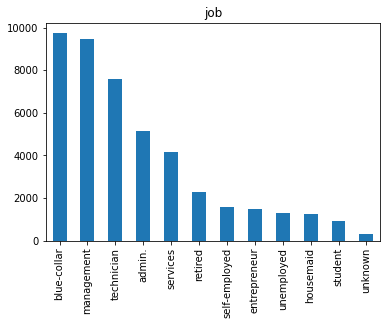

In [19]:
df.job.value_counts().plot.bar(title='job')

<AxesSubplot:title={'center':'education'}>

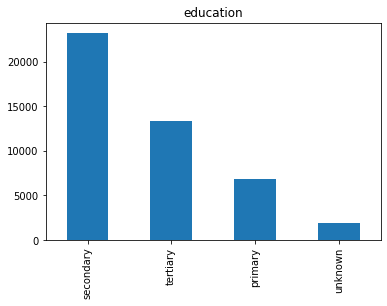

In [20]:
df.education.value_counts().plot.bar(title='education')

Since we only have a few unknown jobs, and only a few more unknown educations, and one's education is arguably correlated with one's job, we are going to determine unknown educations through jobs and unknown jobs through educations. To achieve this, we will calculate the education distribution of each job.

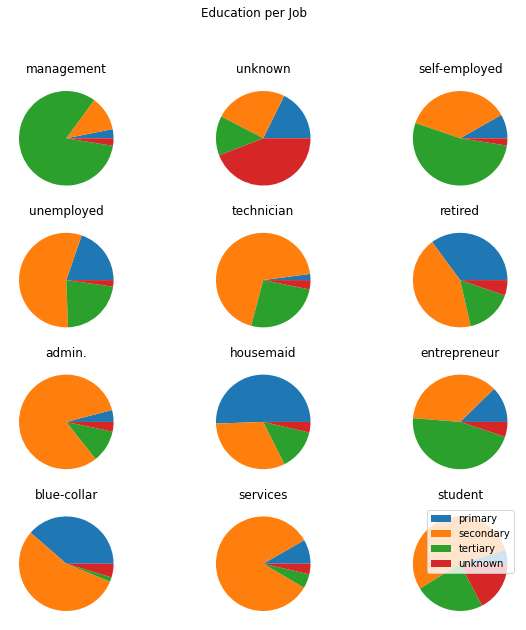

In [21]:
fig, axs = plt.subplots(4,3, figsize=(10,10))
fig.suptitle('Education per Job')
ij = 0
i = 0
j = 0
for job in df["job"].unique():
    education_counts = df[df["job"] == job]["education"].value_counts().sort_index()
    patches, texts = axs[i,j].pie(education_counts)
    axs[i,j].set_title(job)
    plt.legend(patches, ['primary','secondary','tertiary','unknown'], loc="best")
    ij += 1
    i = ij % 4
    j = ij % 3

When we replace the education values in our dataset, we're going to try to maintain the relative distribution we had before.

That is, say we had 10 unknowns and 10 knowns for a certain job category. If 2 had primary education, 3 had secondary education, and 5 had tertiary education, then we want to turn 2 of the unknowns into primary, 3 of the unknowns into secondary, and 5 of the unknowns into tertiary.

We believe this is justified because there are relatively few unknowns in either the job or education columns in the first place, and this will help us maintain the prior distribution while eliminating unknowns.

In [22]:
# first we calculate the conditional distributions
# which will exclude the unknowns
education_percentages = dict()
for job in df["job"].unique():
    education_counts = df[df["job"] == job]["education"].value_counts()
    total = education_counts["tertiary"] + education_counts["secondary"] + education_counts["primary"]
    education_percentages[job] = {}
    tertiary_percentage = education_counts["tertiary"] / total
    secondary_percentage = education_counts["secondary"] / total
    primary_percentage = education_counts["primary"] / total
    total_unknown = education_counts["unknown"]
    education_percentages[job]["tertiary"] = math.ceil(tertiary_percentage * total_unknown)
    education_percentages[job]["secondary"] = math.ceil(secondary_percentage * total_unknown)
    education_percentages[job]["primary"] = math.ceil(primary_percentage * total_unknown)

# then we are going to distribute the unknowns
# based on our calculations
for index, row in df.iterrows():
    if row["education"] == "unknown":
        if education_percentages[row["job"]]["tertiary"] != 0:
            df.loc[index, ["education"]] = "tertiary"
            education_percentages[row["job"]]["tertiary"] -= 1
        elif education_percentages[row["job"]]["secondary"] != 0:
            df.loc[index, ["education"]] = "secondary"
            education_percentages[row["job"]]["secondary"] -=1
        else:
            df.loc[index, ["education"]] = "primary"
    else:
        continue

If we display the updated pie charts, we can visually confirm if our proportions match with what we had before, just without the unknowns.

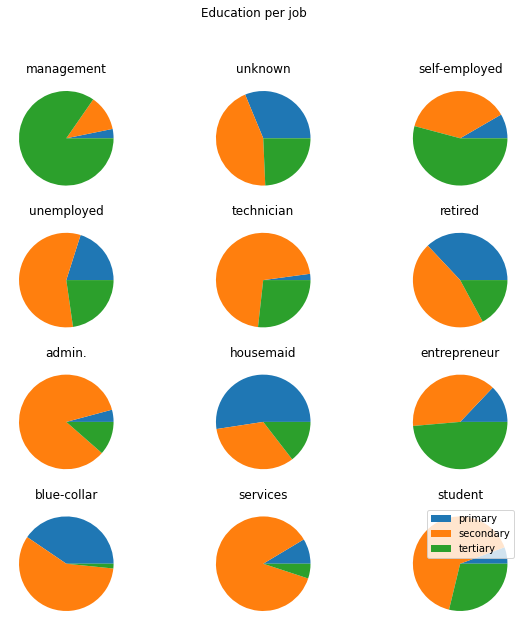

In [23]:
# after replacement
fig, axs = plt.subplots(4,3, figsize=(10,10))
fig.suptitle('Education per job')
ij = 0
i = 0
j = 0
for job in df["job"].unique():
    education_counts = df[df["job"] == job]["education"].value_counts().sort_index()
    patches, texts = axs[i,j].pie(education_counts)
    axs[i,j].set_title(job)
    plt.legend(patches, ['primary','secondary','tertiary'], loc="best")
    ij += 1
    i = ij % 4
    j = ij % 3

Since there are more job types than education types, we are just going to go ahead and replace the unknown jobs through mode instead. We can see that tertiary is usually management, secondary is usually blue-collar, and primary is usually blue-collar.

In [24]:
for education in df["education"].unique():
    job_counts = df[df["education"] == education]["job"].value_counts()
    print(education)
    print(job_counts.head(1))
    print()

tertiary
management    8006
Name: job, dtype: int64

secondary
blue-collar    5634
Name: job, dtype: int64

primary
blue-collar    3941
Name: job, dtype: int64



In [25]:
# Replacement
df.loc[(df.job == "unknown") & (df.education == "tertiary"), "job"] = "management"
df.loc[(df.job == "unknown") & (df.education == "secondary"), "job"] = "blue-collar"
df.loc[(df.job == "unknown") & (df.education == "primary"), "job"] = "blue-collar"

### Unknown Contact Methods

Now let us consider the contact column. Although there are even more unknowns compared to telephone, the dataset still manages to show a large majority of contacts were through cellular.

cellular     64.8%
unknown      28.8%
telephone     6.4%
Name: contact, dtype: object


<AxesSubplot:title={'center':'Contact'}>

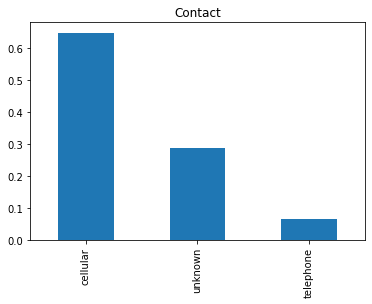

In [26]:
contact_dist = df['contact'].value_counts(normalize=True)
print(contact_dist.mul(100).round(1).astype(str) + '%')
contact_dist.plot.bar(title='Contact')

Because of this, we are going to go ahead and fill in the unknowns with the mode value, which is cellular.

In [27]:
contact_mode = df["contact"].mode()
df["contact"].replace(["unknown"], contact_mode,inplace = True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,tertiary,no,1506,yes,no,cellular,5,may,92,1,-1,0,unknown,no
4,33,management,single,tertiary,no,1,no,no,cellular,5,may,198,1,-1,0,unknown,no


### Dropping poutcome

Unfortunately, 81.7% of poutcome's values are unknown. While there is definitely an argument to just replace these unknowns with failures, it comes to question why they weren't marked as a failure in the first place. This suggests to us that we should just go ahead and drop this column.

In [28]:
df.drop(columns=['poutcome'], inplace=True)
print("poutcome in columns: ",('poutcome' in df.columns))

poutcome in columns:  False


## Numerical Features

As for our numerical features, we want to ask ourselves the following questions:

1. Are there any extreme outliers?

2. Are our distributions relatively normal (for Naive Bayes), or do we have to perform binning?

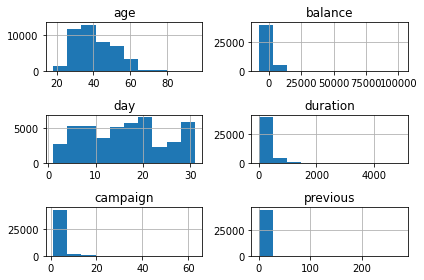

In [29]:
numeric = ['age','balance','day','duration','campaign','previous']
df.hist(column=numeric)
plt.tight_layout()

Looks like we have a couple of outliers here, making many of our distributions right-skewed, although they appear to be inputted correctly. Now let us take a closer look at each of the numerical features, and handle these appropriately.

### Previous

<AxesSubplot:>

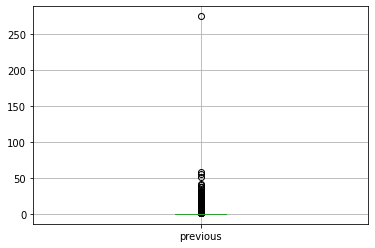

In [30]:
df.boxplot(column=['previous'])

It appears that there is only one outlier for the previous column. We will simply substitute it with the second highest value.

before:
29182    275
38326     58
Name: previous, dtype: int64

after:
29182    58
38326    58
Name: previous, dtype: int64


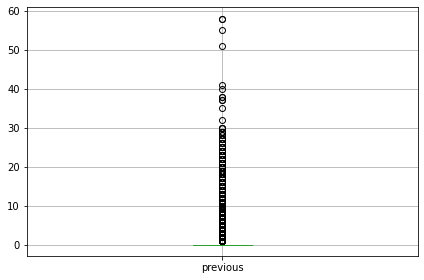

In [31]:
print('before:')
two_largest_previous_original = df.previous.nlargest(2)
print(two_largest_previous_original)

df.loc[two_largest_previous_original.idxmax(), 'previous'] = two_largest_previous_original.min()

print('\nafter:')
print(df.previous.nlargest(2))

df.boxplot(column=['previous'])
plt.tight_layout()

### Balance



Summary Descriptives:
min:  -8019
lower:  -1962.0
Q1:  72.0
median:  448.0
mean:  1362.2720576850766
Q3:  1428.0
upper:  3462.0
max:  102127


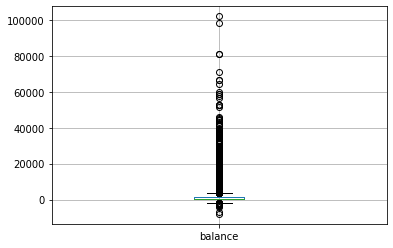

In [32]:
df.boxplot(column=['balance'])

Q1 = df.balance.quantile(0.25)
Q3 = df.balance.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

print('Summary Descriptives:')
print('min: ', df.balance.min())
print('lower: ',lower)
print('Q1: ',Q1)
print('median: ', df.balance.median())
print('mean: ', df.balance.mean())
print('Q3: ',Q3)
print('upper: ',upper)
print('max: ', df.balance.max())

Now this one is more interesting! True to the idea of wealth inequality, it seems that while the median balance is a measly 448, the top balances have far more. Additionally, we even have negative balances! Let's make a few more graphs to see what's going on here.

negative balances:  3766


<AxesSubplot:>

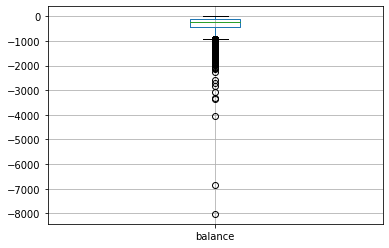

In [33]:
negative_balance_df = df[df.balance < 0]

print('negative balances: ', negative_balance_df.balance.size)

negative_balance_df.boxplot(column='balance')

high balances:  4712


<AxesSubplot:>

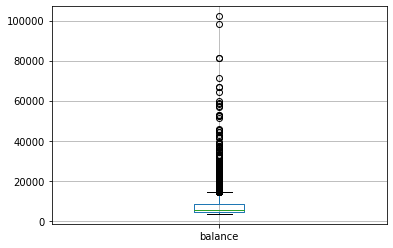

In [34]:
high_balance_df = df[df.balance > upper]

print('high balances: ', high_balance_df.balance.size)

high_balance_df.boxplot(column='balance')

For the purpose of this analysis, we will bin this feature into 4 categories based off of our summary statistics. This should create relatively even-filled bins.

In [35]:
def balance_binning(x):
    if x.balance < Q1: # short
        return 0
    elif x.balance <= df.balance.median(): # medium
        return 1
    elif x.balance <= Q3: # long
        return 2
    else: # very long
        return 3

balance_binned = df.apply(
    lambda row : balance_binning(row),
    axis = 1
)

print(balance_binned.value_counts())

df['balance'] = balance_binned

1    11330
2    11306
3    11297
0    11278
dtype: int64


### Age



95

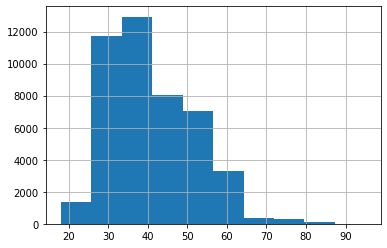

In [36]:
df.age.hist()

df.age.max()

While age is a right-skewed dataset, and that there are definitely outliers, the max age is only 95. Because of this, we are willing to not make any changes to this feature.

### Duration

<AxesSubplot:>

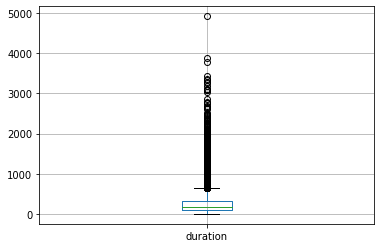

In [37]:
df.boxplot(column=['duration'])

Similar to balance, we have more than one outlier. Let's once again look at the summary statistics.

In [38]:
Q1 = df.duration.quantile(0.25)
Q3 = df.duration.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

print('Summary Descriptives:')
print('min: ', df.duration.min())
print('lower: ',lower)
print('Q1: ',Q1)
print('median: ', df.duration.median())
print('mean: ', df.duration.mean())
print('Q3: ',Q3)
print('upper: ',upper)
print('max: ', df.duration.max())

Summary Descriptives:
min:  0
lower:  -221.0
Q1:  103.0
median:  180.0
mean:  258.1630797814691
Q3:  319.0
upper:  643.0
max:  4918


Using these summary statistics, let's bin duration into 4 bins.

In [39]:
def duration_binning(x):
    if x.duration < Q1: # short
        return 0
    elif x.duration <= df.duration.median(): # medium
        return 1
    elif x.duration <= Q3: # long
        return 2
    else: # very long
        return 3

duration_binned = df.apply(
    lambda row : duration_binning(row),
    axis = 1
)

print(duration_binned.value_counts())

df['duration'] = duration_binned

1    11454
2    11290
3    11261
0    11206
dtype: int64


### Campaign

<AxesSubplot:>

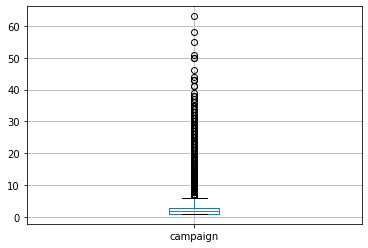

In [40]:
df.boxplot(column=['campaign'])

For campaign, we see yet another similar story to duration and balance, so we will once again use summary statistics to bin our data.

In [41]:
Q1 = df.campaign.quantile(0.25)
Q3 = df.campaign.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

print('Summary Descriptives:')
print('min: ', df.campaign.min())
print('lower: ',lower)
print('Q1: ',Q1)
print('median: ', df.campaign.median())
print('mean: ', df.campaign.mean())
print('Q3: ',Q3)
print('upper: ',upper)
print('max: ', df.campaign.max())

Summary Descriptives:
min:  1
lower:  -2.0
Q1:  1.0
median:  2.0
mean:  2.763840658246887
Q3:  3.0
upper:  6.0
max:  63


In [42]:
def campaign_binning(x):
    if x.campaign < Q1: # short
        return 0
    elif x.campaign <= df.campaign.median(): # medium
        return 1
    elif x.campaign <= Q3: # long
        return 2
    else: # very long
        return 3

campaign_binned = df.apply(
    lambda row : campaign_binning(row),
    axis = 1
)

print(campaign_binned.value_counts())

df['campaign'] = campaign_binned

1    30049
3     9641
2     5521
dtype: int64


## Label Distribution

Let us consider the distribution of our label, y. If there is a class imbalance in our training set, then we potentially want to mitigate that.

no     88.3%
yes    11.7%
Name: y, dtype: object


<AxesSubplot:>

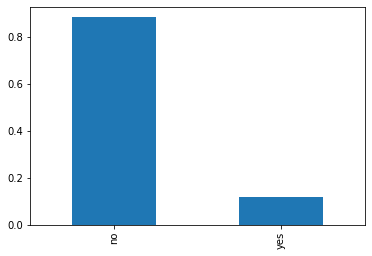

In [43]:
label_dist = df['y'].value_counts(normalize=True)
print(label_dist.mul(100).round(1).astype(str) + '%')
label_dist.plot.bar()

Obviously, it turns out that most people will not subscribe a term deposit! To mitigate this, we are going to use SMOTE (Synthetic Minority Over-Sampling Technique). Recall that this means creating more artificial minority class instances randomly.

## Feature Engineering

### Reinterpreting pdays

Looking at the pdays column, we notice that the majority of rows actually have -1 for pdays. This means that a minority of rows have an actual ordinal numerical value for pdays.

In [44]:
print("Never contacted (-1): ",df[df['pdays'] == -1]['pdays'].count())
print("Contacted (!=-1): ",df[df['pdays'] != -1]['pdays'].count())

Never contacted (-1):  36954
Contacted (!=-1):  8257


Therefore, let us convert this into a binary categorical variable that shows if the client was even contacted at all (yes/no).

In [45]:
df.pdays = df.pdays.map(lambda x: 0 if x == -1 else 1)
df.rename(columns={'pdays':'previouslycontacted'}, inplace=True)
df.previouslycontacted.value_counts()

0    36954
1     8257
Name: previouslycontacted, dtype: int64

### Year and Day of the Week

Since the dataset is sorted, and we know that it starts from 2008, we can calculate the year and day of the week for each data point.

In [46]:
# create year column
curYear = 2008
janStretch = False
yearList = []
for ind in df.index:
    if df['month'][ind] == 'jan' and not janStretch:
        janStretch = True
        curYear += 1  
    elif df['month'][ind] != 'jan':
        janStretch = False
    yearList.append(curYear) 
df['year'] = yearList

# create day of week column
# create a list then add to dataframe df
temp = pd.Timestamp('2022-4-5')
monthToNum = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,
                'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}

dayOfWkList = []
for ind in df.index:
    year = df['year'][ind]
    month = df['month'][ind]
    day = df['day'][ind]
    timestampStr = str(year) + '-' + str(month) + '-' + str(day)
    dayOfWk = pd.Timestamp(timestampStr)
    dayOfWkList.append(dayOfWk.day_of_week)
df['dayOfWk'] = dayOfWkList
df[['year','month','day','dayOfWk']].head()

,year,month,day,dayOfWk
0,2008,may,5,0
1,2008,may,5,0
2,2008,may,5,0
3,2008,may,5,0
4,2008,may,5,0


### One-Hot Encoding

To run our data through the classifiers, we need to transform our nominal categorical data into many binary categorical variables.

In [47]:
# one hot encoding for all categorical columns
from sklearn.preprocessing import OneHotEncoder
categorical_list = ["job", "marital"]
for col in categorical_list:
    encoder = OneHotEncoder()
    # makes a dataset. each column is a value in the column from the original dataset. the new cloumns are sorted based on the values!
    col_encoder = pd.DataFrame(encoder.fit_transform(df[[col]]).toarray())
    # get the list of values in the current column and sort them so you can change the names
    list_of_vals = col + "_" + df[col].unique()
    list_of_vals.sort()
    col_encoder.columns = list_of_vals
    df = df.join(col_encoder)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single
0,58,management,married,tertiary,no,3,yes,no,cellular,5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,44,technician,single,secondary,no,0,yes,no,cellular,5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,33,entrepreneur,married,secondary,no,0,yes,yes,cellular,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,47,blue-collar,married,tertiary,no,3,yes,no,cellular,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,33,management,single,tertiary,no,0,no,no,cellular,5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
from calendar import month_abbr
# Converting Ordinal Columns
# monthMap = [m.lower() for m in month_abbr]
df['month'] = df['month'].map(monthToNum)

educationToNum = {"primary": 1, "secondary": 2, "tertiary": 3}
df['education'] = df['education'].map(educationToNum)
print(df['education'])

0        3
1        2
2        2
3        3
4        3
        ..
45206    3
45207    1
45208    2
45209    2
45210    2
Name: education, Length: 45211, dtype: int64


#### Binary Categorical Variables

Let us map all binary categorical variables (including y) so that "yes" = 1, and "no" = 0.

Additionally, let contact be mapped so that "cellular" = 1 and "telephone" = 0

In [49]:
# includes label
binary_categorical = ['default','housing','loan','y']

for col in binary_categorical:
    df[col] = df[col].map({'yes': 1, 'no': 0})

# includes contact because we removed the "other" value
df['contact'] = df['contact'].map({'cellular': 1, 'telephone': 0})

df[binary_categorical + ['contact']].head()

,default,housing,loan,y,contact
0,0,1,0,0,1
1,0,1,0,0,1
2,0,1,1,0,1
3,0,1,0,0,1
4,0,0,0,0,1


## SMOTE

As mentioned before, we should run SMOTE on our dataset since there is a class imbalance between the distribution of yes and no.

In [50]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [51]:
# SMOTE-IFIED DATA
features = df.drop(columns=['job', 'marital', 'y'])
labels = df['y']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)

sm = SMOTE()
X_sm, y_sm = sm.fit_resample(features, labels)
print(type(X_sm))

print(y_sm.value_counts())
print(len(X_sm))

<class 'pandas.core.frame.DataFrame'>
0    39922
1    39922
Name: y, dtype: int64
79844


## Modeling and Results

Finally, we can start to perform modeling on our data. Below shows the fruit of our labor. We will display the results as we go.

In [52]:
# IMPORTS
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


In [53]:
print(features.head())
print(labels)
print(features.dtypes)
print(len(features.columns))

   age  education  default  balance  housing  loan  contact  day  month  \
0   58          3        0        3        1     0        1    5      5   
1   44          2        0        0        1     0        1    5      5   
2   33          2        0        0        1     1        1    5      5   
3   47          3        0        3        1     0        1    5      5   
4   33          3        0        0        0     0        1    5      5   

   duration  ...  job_management  job_retired  job_self-employed  \
0         2  ...             1.0          0.0                0.0   
1         1  ...             0.0          0.0                0.0   
2         0  ...             0.0          0.0                0.0   
3         0  ...             0.0          0.0                0.0   
4         2  ...             1.0          0.0                0.0   

   job_services  job_student  job_technician  job_unemployed  \
0           0.0          0.0             0.0             0.0   
1           

### Decision Tree

Starting off with the decision tree classifier, we perform a full grid search CV to find the best parameters for the decision tree. We then perform the cross validation loop and check our metrics.

In [54]:
clf = DecisionTreeClassifier()

parameters = {
    "max_depth" : [1,2,3,4],
    "min_samples_leaf": [1,2,3,4],
    "max_features": [20, 25, 29]
    }

grid_search = GridSearchCV(clf, parameters, cv=3, scoring='accuracy')
grid_search.fit(X_sm, y_sm)

print(grid_search.best_params_)
print("Accuracy:", grid_search.best_score_*100)
nested_score = cross_val_score(grid_search, X_sm, y_sm, cv=10)
print("Accuracy:", nested_score.mean()*100)

{'max_depth': 3, 'max_features': 25, 'min_samples_leaf': 4}
Accuracy: 67.63285367616635
Accuracy: 65.11382172610719


### Naive Bayes

Next with Naive Bayes, we use a 10-fold cross validation to determine its effectiveness and print out accuracy and a classification report.

In [55]:
# Naive Bayes
clf = GaussianNB()
scores = cross_val_score(clf, X_sm, y_sm, cv=10)
print("Accuracy:", scores.mean()*100)

#Gives precision, recall, accuracy, etc
predictions = cross_val_predict(clf, X_sm, y_sm, cv=10)
print("--Classification--\n", classification_report(y_sm, predictions))

Accuracy: 72.14913091681171
--Classification--
               precision    recall  f1-score   support

           0       0.78      0.61      0.69     39922
           1       0.68      0.83      0.75     39922

    accuracy                           0.72     79844
   macro avg       0.73      0.72      0.72     79844
weighted avg       0.73      0.72      0.72     79844



### KNN

Now let's use a KNN classifier and see how it fares on our data. We must first scale our data to ensure the units of one column don't dominate another in distance calculations. We use a pipeline with PCA and perform cross validation with our KNN model to print out our accuracy.

In [56]:
# Knn and Pipelines
scaler = StandardScaler()
knn = KNeighborsClassifier()
pca = PCA()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('knn', knn)])
scores = cross_val_score(pipe, X_sm, y_sm, cv=5)
print("Accuracy:", scores.mean()*100)
predictions = cross_val_predict(pipe, X_sm, y_sm, cv=10)
print("Classification report:\n", classification_report(y_sm, predictions))

Accuracy: 80.64339893701863
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.73      0.81     39922
           1       0.78      0.92      0.84     39922

    accuracy                           0.83     79844
   macro avg       0.84      0.83      0.82     79844
weighted avg       0.84      0.83      0.82     79844



### Resampling

The following classifiers have a high time complexity. For example, nonlinear SVM training takes O(n_samples^2 * n_features) time. Unfortunately, we have about 80,000 records (augmented by SMOTE). Therefore, we are going to reduce the amount of samples we are working with for the rest of our modeling.

In [57]:
# sampled = df.sample(n=5000, random_state=0)
# features_sample = sampled
sample_df = X_sm.sample(n=5000, random_state=0)
# sample_labels = y_sm.
# print(sample_df.head())
# vectorize getting labels corresponding to each sampled feat
sample_labels_df = y_sm.loc[sample_df.index]
# print(sample_labels_df.head())
sample_labels_df.value_counts()
# for row in sample.index:
#     sample_labels_df.y_sm.loc[row] 

1    2599
0    2401
Name: y, dtype: int64

### Neural Networks

We create a neural net model, with different hidden layer sizes and activation functions, determining which would perform that best with our data. We search parameters using a randomized search cv because that's faster than a full grid search cv. Finally we perform cross validation to determine the score of our model and print out our accuracy.

In [58]:
# neural nets

simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UserWarning)

scaler = StandardScaler()
mlp = MLPClassifier()

param_dist = {
    'mlp__hidden_layer_sizes': [10,20],
    'mlp__activation': ['logistic','tanh','relu']
}

pipe = Pipeline([('scaler', scaler), ('mlp',mlp)])
random_search = RandomizedSearchCV(pipe, param_dist, random_state=0, cv=5, scoring='accuracy')
# clf = RandomizedSearchCV(pipe, param_dist, random_state=0)
# grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

# scores = cross_val_score(random_search, sample_df, sample_labels_df, cv=5)
# print("Accuracy:", scores.mean()*100)
predicts = cross_val_predict(random_search, sample_df, sample_labels_df, cv=10)
print("Classification report\n", classification_report(sample_labels_df, predicts))

Classification report
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      2401
           1       0.84      0.87      0.85      2599

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



### SVM

Similarly, let's run the data through a SVM.

In [ ]:
# svms

simplefilter("ignore", category=UserWarning)

svc = SVC(probability=False,gamma='auto') # optimization parameters

param_dist = {
    'pca__n_components': list(range(3, 6)),
    'svc__kernel': ['linear','rbf','poly']
}

pipe = Pipeline([('scaler', scaler), ('pca', pca), ('svc', svc)])

# grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
random_search = RandomizedSearchCV(pipe, param_dist, scoring='accuracy', random_state=0)

scores = cross_val_score(random_search, sample_df, sample_labels_df, cv=5)
print("Accuracy: ", scores.mean()*100)
print()

predict = cross_val_predict(random_search, sample_df, sample_labels_df, cv=10)
print("--Classification--\n", classification_report(sample_labels_df, predict))


Accuracy:  76.14

--Classification--
               precision    recall  f1-score   support

           0       0.77      0.73      0.75      2401
           1       0.76      0.80      0.78      2599

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000



### Ensemble Classifiers

Finally, we are going to use Random Forest and AdaBoost ensemble classifiers to end off our modeling.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

simplefilter("ignore", category=UserWarning)

params_grid = {
    'max_depth': list(range(35, 46)),
    'min_samples_leaf': [8, 10, 12],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(rfc, params_grid, cv=5, scoring='accuracy')
scores = cross_val_score(random_search, X_sm, y_sm, cv=5)
print('Accuracy:', scores.mean()*100)

Accuracy: 71.56434393302857


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=150)
scores = cross_val_score(abc, X_sm, y_sm, cv=5)
print('Accuracy:', scores.mean()*100)

Accuracy: 77.71137475025196


# Conclusion

Overall, it seems that our neural network performed the best, with a positive class f-score of 0.85 and an overall accuracy of 84%. However, that is not to discredit our other classifiers, since they all performed at a >65% accuracy rate. Additionally, recall that our neural network only samples 5000 of the 80,000 SMOTE dataset.

When it came to exploring and engineering our dataset, we were most proud of our Year and Day of the Week columns, since it relied on a very special characteristic from out dataset (being in date order). When it came to our numerical features, we found that most of their distributions were right-skewed, which tells an interesting story about the wealth gap among bank clients. Among our categorical features, we found the different challenges and nuances with unknown values to be very interesting, especially where we were able to estimate unknown jobs using education distributions and unknown educations using known jobs.

What we learned from this experience was that choosing our classifiers was only a small part of the data science process. The more impactful questions that one must ask themselves are:

- What are the distributions present in our dataset? If we do not have a normal distribution, how can we mitigate that?
- What is the nature of each feature? Do we have any background knowledge to help us interpret it?
- Where did the dataset come from? Is there any information about the dataset that isn't necessarily present in the .csv file?
- How should we handle a class imbalance?

Finally, when running our models we epxerienced the hard way that scikit learn does not handle large data sets well for models such as neural nets and svm, and takes an extremely long time to execute. Of course you would expect that larger data sets would take longer, espcially on neural nets and svm which use cross validation. All of those iterations can take a lot of time, but after exploring online it seems that scilit learn is not the best library to use for large data sets. We were able to make a few optimizations such as using RandomizedSearchCV instead of GridSearchCV and randomly sampling 5000 out of 80000 of our SMOTE data to make things run faster. Of course, we realize that the model can be overfitted for that particular sample of the data set, but since the whole data set might take a few hours, it was a decision we had to make. A potential future workaround to use when working with large data sets in sci kit learn, is to split up the data set and run our models in parallel on a cloud cluster machine. 


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=825dc3e6-d277-4188-bb22-3ec9a91d5af7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>